Whale optimization algorithm is a meta heuristic algorithm similar to grey wolf optimization. However, instead of a complete hierarchy, there is only a leader present, alll other search agents update their positions based on the position of leader. There is a continuous switching between exploration and exploitation. 

Here the fitness function is borrowed from Grey wolf optimization. 

In [27]:
# importing required libraries 
import numpy as np 
import matplotlib.pyplot as plt
np.random.seed(0)  # seeding for repeatable results

A note regarding the format of data that has been stored and manipulated. Each of the whale in this algorithm denote an entire configuration of source and receivers. Each whale is a 1D vector with index 0,1 representing the source position and then x,y (in that sequence) coordinates of each of the receiver in subsequent space.

In [28]:
# defining a suitable fitness function
n_rec = 51 # number of receivers
def fitness(pos_matrix,ToA,wave_vel):
    '''The function returns the error value for a given position matrix(pos_matrix) consisting of source location as the first element
    and the receiver positions as all the rest elements. ToA is a vector of the time of arrival of seismic waves for receivers
    Wave_vel is the velocity of waves'''
    
    n_rec = np.shape(ToA)[0]
    TDoA = np.zeros(shape= (n_rec-1)) # created a new variable which will store time difference wrt the first receiver
    TDoA[:] = (ToA[1:] - ToA[0]).reshape(n_rec-1)
    # Now getting the value for time of arrival from the position of source and receivers
    pos_matrix.reshape((n_rec+1)*2)
    ToA_pos = np.zeros(shape=n_rec)
    pos_diff = np.zeros(shape = (np.shape(pos_matrix)[0]))  # vector denoting the position of receivers wrt source
    pos_diff_x= (pos_matrix[2::2] - pos_matrix[0])#.reshape(n_rec)  # x coordinate difference
    pos_diff_y= (pos_matrix[3::2] - pos_matrix[1])#.reshape(n_rec)
    ToA_pos[:] = np.sqrt(np.multiply(pos_diff_x,pos_diff_x)+ np.multiply(pos_diff_y,pos_diff_y))/wave_vel
    TDoA_pos = np.zeros_like(TDoA)
    TDoA_pos[:] = (ToA_pos[1:] - ToA_pos[0]).reshape(n_rec-1)
    error_vector = TDoA_pos - TDoA
    error = np.dot(error_vector.T,error_vector)
    return error

In [29]:
# Testing the fitness function with a simple case
pos_matrix = np.array([0,0,1,0,-2,0,0,0,0,0]) # source at (0,0), receiver at (1,1) and another reciver at [-2,0]
toa_actual = np.array([1,2]) # time taken will be 1s with wave velocity of 1 m/s
toa_given = np.array([1,0,0,0]) # for this case, the answer should come out to be 4 s^2
print(fitness(pos_matrix,toa_given,1))

4.0


In [30]:
# Now generating the synthetic data for testing
wave_vel = 1000 # m/s
rec_pos_actual =300 + np.random.normal(loc=0.0,scale =50,size = (n_rec,2))  # actual position for 2 receivers
src_pos_actual = np.array([0,0])
t_rec_ideal = np.zeros(shape =(n_rec,1))
# calculating the ideal time of arrival
t_rec_ideal[0:n_rec] = np.sqrt((rec_pos_actual[0:n_rec,1]-src_pos_actual[1])**2 + (rec_pos_actual[0:n_rec,0]-src_pos_actual[0])**2).reshape(n_rec,1)
#introducing noise to account for error in onset detection and sensor
noise_t = np.random.normal(loc=0.0,scale =0.2,size = (n_rec,1))
t_Rec_real = np.array(t_rec_ideal + noise_t)

In [31]:
# Now generating some random solutions for input and intializing number of wolves and their types, alpha, beta and delta are taken to be one each 

n_whales = 32 # number of whales

initial_pos = 300  + np.random.normal(loc=0.0,scale =50,size = (n_whales,(n_rec+1)*2))  # in order to make sure that the spread is in entire domain

In [36]:
n_iter = 1000# number of iterations

In [37]:
def Whale_optimization(n_iter,n_whales,initial_pos,t_Rec_real):
    '''The function returns the optimzed location for leader in the search space according to Whale Optimization algorithm.
    n_iter = number of iterations
    n_whales = number of whales
    initial_pos = initial position of all whales'''
    
    TOA_min = np.min(t_Rec_real)
    TOA_max = np.max(t_Rec_real)
    TOA_avg = np.mean(t_Rec_real)
    whales_pos = np.copy(initial_pos)  
    fitness_array =np.zeros(n_iter)
    
    fitness_value = np.zeros(n_whales)
   
    # Assigning the position and fitness for leader
    n_rec = int(np.shape(initial_pos)[1]/2-1) # number of receiver
    leader_fitness = 10**6#fitness_value[0]
    leader_pos = np.copy(whales_pos[0]) 
    

        # Now updating the position
    for i in range(n_iter):  
        fitness_array[i] = leader_fitness
        # Defining parameters for updating positions
        a =  2 - i*2/n_iter# scalar
   # a2 = -1 + i*(-1/n_iter)  needed?
        for j in range(n_whales):
            r1 = np.random.random(size=(n_rec+1)*2)#vector       
            r2 = np.random.random(size=(n_rec+1)*2)#vector
            A = 2*a*r1 - a #vector
           
            C =2*r2#vector
           
            b = 1# may vary
            #l = (a2-1)*np.random.random() + 1       #needed?
            p = np.random.random()
            
            if p < 0.5:
                if np.dot(A,A) < 1:# mod A less than 1
                    D=np.absolute(np.multiply(C,leader_pos)-whales_pos[j])# prey interpreted as leader
                   
                    whales_pos[j] = leader_pos - np.multiply(A,D)
                    
                    # the following needs modification
                    #to prevent whales from esaping boundaries
                   # if (whales_pos[j,k] > =350 or whales_pos[j,k] =<250 ):# currently specific, will need to generaliz
                      #  whales_pos[j,k] = 250 + 100*np.random.random()
                
                else: #if dot(A.A)>=1
                        random_whale_index = np.random.randint(low=0,high=n_whales)
                        Random_whale_pos = whales_pos[random_whale_index]
                        D=np.absolute(np.multiply(C,Random_whale_pos)-whales_pos[j])
                   
                        whales_pos[j] = Random_whale_pos - np.multiply(A,D)
                      
                    # to prevent whales from escaping the boundaries
                   # if (whales_pos[j,k] > =350 or whales_pos[j,k] =<250) :# currently specific, will need to generaliz
                   #     whales_pos[j,k] = 250 + 100*np.random.random()                
            else :#if p>=0.5   best solution interpreted as leader
                D = np.absolute(leader_pos-whales_pos[j])
                t=np.random.uniform(-1,1)# "b" constant and defined much earlier
                whales_pos[j]=D*np.exp(b*t)*np.cos(2*np.pi*t)+ leader_pos[j]
                
                        
                        
                        
                        
               # for k in range(np.size(leader_pos)):
                #    Dist_leader = abs(leader_pos[k] - whales_pos[j,k])
                 #   whales_pos[j,k] = Dist_leader*np.exp(b*k)*np.cos(2*np.pi*l) + whales_pos[j,k]
                
                #
                   # if (whales_pos[j,k] > =350 or whales_pos[j,k] =<250 ):# currently specific, will need to generaliz
                   #     whales_pos[j,k] = 250 + 100*np.random.random()
        
        
                for j in range(n_whales):
                    fitness_value[j] = fitness(whales_pos[j,:],t_Rec_real,wave_vel = wave_vel)
                    if fitness_value[j] <= leader_fitness:
                        leader_fitness = fitness_value[j]
                        leader_pos = np.copy(whales_pos[j]) 
                
    return leader_pos,fitness_array
        

In [38]:
optimized_pos, fitness_array = Whale_optimization(n_iter=n_iter,n_whales =n_whales,initial_pos = initial_pos,t_Rec_real=t_Rec_real)

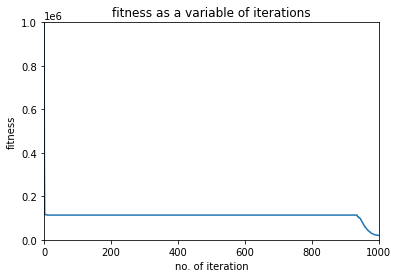

[1000000.          353071.76797301  115833.3094675   115833.3094675
  115833.3094675   115833.3094675   115833.3094675   115491.05520707
  115491.05520707  113657.79923044  113657.79923044  113657.79923044
  113657.79923044  113657.79923044  113657.79923044  113657.79923044
  113657.79923044  113657.79923044  113657.79923044  113657.79923044
  113657.79923044  113657.79923044  113657.79923044  113657.79923044
  113657.79923044  113657.79923044  113657.79923044  113657.79923044
  113657.79923044  113657.79923044  113657.79923044  113657.79923044
  113657.79923044  113657.79923044  113657.79923044  113657.79923044
  113657.79923044  113657.79923044  113657.79923044  113657.79923044
  113657.79923044  113657.79923044  113657.79923044  113657.79923044
  113657.79923044  113657.79923044  113657.79923044  113657.79923044
  113657.79923044  113657.79923044  113657.79923044  113657.79923044
  113657.79923044  113657.79923044  113657.79923044  113657.79923044
  113657.79923044  113657.79923044 

In [39]:
import matplotlib.pyplot as plt
index_of_iteration= list( range(0,n_iter))
plt.plot(index_of_iteration,fitness_array)
plt.xlabel("no. of iteration")
plt.ylabel("fitness")
plt.title("fitness as a variable of iterations")
plt.xlim(0,n_iter)
plt.ylim(-1,10**6)
plt.show()
print(fitness_array)

In [10]:

a=(1,2)
print(a,np.dot(a,a))

(1, 2) 5


In [11]:
a= np.ones(104)

In [12]:
np.random.uniform(-1,1)

0.805690521213372

b is arbitaray
prevneting whales from escaping
a2 and l needed?


In [13]:
r1 = np.random.random(size=(n_rec+1)*2)#vector
print(r1)
for i in range (0,r1.size): r1[i]=abs(r1[i])
print(r1)    

[0.95506739 0.90317462 0.15840591 0.47820639 0.00497866 0.91398483
 0.19116224 0.4664596  0.4400297  0.95775289 0.73662148 0.80432634
 0.87157158 0.54458958 0.57349528 0.79143132 0.13233221 0.63171636
 0.19698958 0.94120121 0.85892342 0.53987811 0.93400126 0.31372203
 0.49033385 0.98654609 0.08266205 0.08753464 0.44687625 0.60947217
 0.84498841 0.25949303 0.33190644 0.73569313 0.16394268 0.45076995
 0.204264   0.50762911 0.04935493 0.50651256 0.12336187 0.87747278
 0.63922327 0.76662461 0.74515085 0.8159263  0.64805951 0.99303071
 0.91305212 0.40018916 0.51814317 0.66156702 0.47115446 0.66571386
 0.92452778 0.40804459 0.17051116 0.93213629 0.70451479 0.60249908
 0.3012975  0.16321344 0.61184208 0.80962256 0.70331736 0.9613517
 0.00409852 0.08997958 0.44018833 0.50116677 0.0201909  0.33122378
 0.23503726 0.94458577 0.26162952 0.64485547 0.35885115 0.6656304
 0.25137875 0.00889018 0.28576988 0.45297709 0.64731827 0.71519183
 0.55241787 0.77526027 0.95385487 0.78456483 0.856983   0.332609

In [14]:
vect=np.array((1,6))

print(2*vect)

[ 2 12]
